# Report

In [211]:
library(ggplot2)
library(dplyr)
library(terra)
library(raster)
library(sf)
library(scales)
library(patchwork)
library(openxlsx)
library(grid)  
library(paletteer)
library(ggspatial) 
library(viridis)
library(units)

# Data

In [212]:
cleaning_data = read.csv("Data/Records/cleaning_data.csv")
insects_records <- read.csv("Data/Records/insects_records_clean.csv")

ecu <- st_read("Data/Shp/ecuador_limits.shp", quiet = TRUE)
buffer = st_read("Data/Shp/buffer_100_km_external.shp")
snap <- st_read("Data/Shp/snap.shp", quiet = TRUE)
natural_regions <- st_read("Data/Shp/ron_2011_no_UTM.shp", quiet = TRUE)

# =========================
# 3) Asegurar CRS = 4326 y geometrías válidas
# =========================
to_4326_valid <- function(x){
  x <- st_make_valid(x)
  if (is.na(st_crs(x))) st_crs(x) <- 4326
  st_transform(x, 4326)
}

ecu <- to_4326_valid(ecu)
snap <- to_4326_valid(snap)
natural_regions <- to_4326_valid(natural_regions)

# =========================
# 4) Convertir registros a puntos sf (4326)
# =========================
stopifnot(all(c("decimalLongitude","decimalLatitude") %in% names(insects_records)))

insects_pts <- st_as_sf(
  insects_records,
  coords = c("decimalLongitude", "decimalLatitude"),
  crs = 4326,
  remove = FALSE
) %>%
  st_make_valid()

# =========================
# 5) Cortar (clip) capas a Ecuador
#    - Puntos: quedarse solo con puntos dentro de Ecuador
#    - Polígonos: recortar a Ecuador
# =========================
ecu_u <- st_union(ecu)

## Sampling completness
sampling_effort = st_read(  "Results/shp/grid_10km_sampling.shp")
sampling_filter = st_read( "Results/shp/grid_10km_sampling_filter.shp")
## Raster data

alpha_div = rast( "Results/raster/GAM_prediction_alpha.tif")
endemism = rast( "Results/GIE/Endemism_consensus.tiff")
density = rast( "Results/raster/records_kernel_density.tiff")
nmds_stack = rast(  "Results/raster/nmds_result.tiff")
cluster_nmds = rast( "Results/raster/cluster_raster_result.tiff")

alpha_kg_likert = rast("Results/raster/alpha_diversity/alpha_conservation_all_clusters_likert5.tif")
endemism_kg_likert = rast("Results/raster/endemism/endemism_conservation_all_clusters_likert5.tif")
alpha_endemism_kg_likert = rast( "Results/raster/alpha_endemism_records/alpha_endemism_records_all_clusters_likert5.tif")


Reading layer `buffer_100_km_external' from data source 
  `C:\PROYECTOS\articulos\Spatial_patterns_insects\CODIGOS\Data\shp\buffer_100_km_external.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 7 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -81.32044 ymin: -5.919045 xmax: -74.29565 ymax: 2.317566
Geodetic CRS:  WGS 84
Reading layer `grid_10km_sampling' from data source 
  `C:\PROYECTOS\articulos\Spatial_patterns_insects\CODIGOS\Results\shp\grid_10km_sampling.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 7268 features and 16 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -81.32114 ymin: -6.003704 xmax: -74.19902 ymax: 2.31959
Geodetic CRS:  WGS 84
Reading layer `grid_10km_sampling_filter' from data source 
  `C:\PROYECTOS\articulos\Spatial_patterns_insects\CODIGOS\Results\shp\grid_10km_sampling_filter.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 162 feat

# Data Distribution

## Report data cleaning

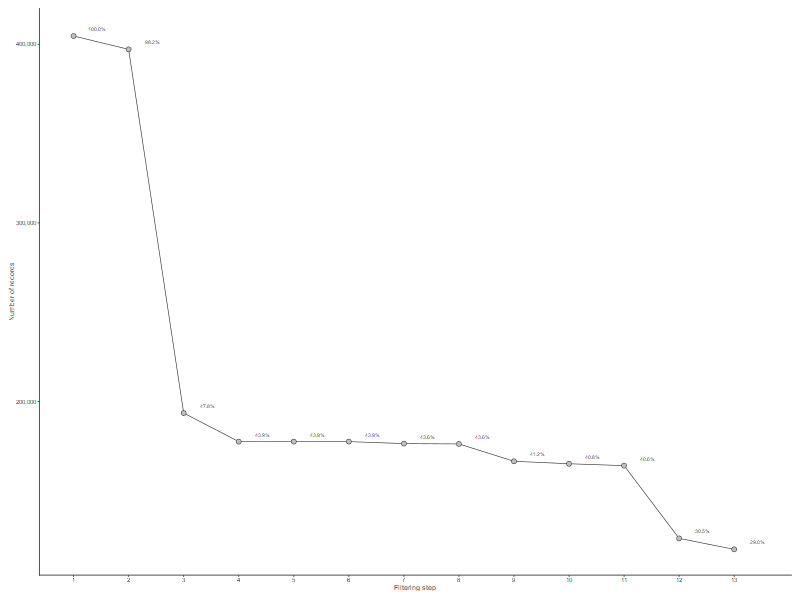

In [213]:
# % retained (optional label)
retained_pct <- 100 * cleaning_data$len_data[nrow(library(scales))] / cleaning_data$len_data[1]

cleaning_data <- cleaning_data %>%
  arrange(steps) %>%
  mutate(
    retained_pct = 100 * len_data / first(len_data),
    decreased_pct = 100 - retained_pct,
    removed_abs = lag(len_data) - len_data,
    removed_pct_prev = 100 * (lag(len_data) - len_data) / lag(len_data)
  )

retained_final  <- cleaning_data$retained_pct[nrow(cleaning_data)]
decreased_final <- cleaning_data$decreased_pct[nrow(cleaning_data)]

filtering_plot <- ggplot(cleaning_data, aes(x = steps, y = len_data)) +
  geom_line(color = "grey20", linewidth = 0.3) +
  geom_point(color = "grey20", fill = "grey75", shape = 21, size = 2.1, stroke = 0.4) +
  geom_text(aes(label = sprintf("%.1f%%", retained_pct), nudge_x = 0.42 ,   nudge_y = 1000),
                vjust = -0.8, size = 1.6, color = "grey20")+
  scale_x_continuous(breaks = cleaning_data$steps) +
  scale_y_continuous(labels = label_comma(accuracy = 1)) +
  labs(x = "Filtering step", y = "Number of records") +
  # Etiqueta final: retenido y disminución acumulada vs inicial

  theme_classic(base_size = 7) +
  theme(
    axis.text = element_text(color = "grey20"),
    axis.title = element_text(color = "grey20"),
    axis.line = element_line(color = "grey20", linewidth = 0.4),
    axis.ticks = element_line(color = "grey20", linewidth = 0.4),
    plot.margin = margin(3, 3, 3, 3, "mm")
  )

filtering_plot

In [214]:
# Single-column width: ~85 mm (common journal 1-column). Height ajustable.
ggsave(
  filename = "Results/Reports/Plots/records_filtering_steps_single_column.png",
  plot = filtering_plot,
  width = 85, height = 70, units = "mm", dpi = 600, bg = "white"
)

## Distribution per taxonomical data

In [215]:
# Puntos dentro de Ecuador
in_ecu <- lengths(st_within(insects_pts, ecu_u)) > 0
insects_pts_ecu <- insects_pts[in_ecu, ]

# Species 

sp_n = length (unique(insects_pts_ecu$scientificName))
genus_n = length(unique(insects_pts_ecu$genus))
families_n = length (unique(insects_pts_ecu$family))

cat("sp: ",sp_n, "genus: ",genus_n, "families: ",families_n)

sp:  8626 genus:  3303 families:  317

## Distribution per order

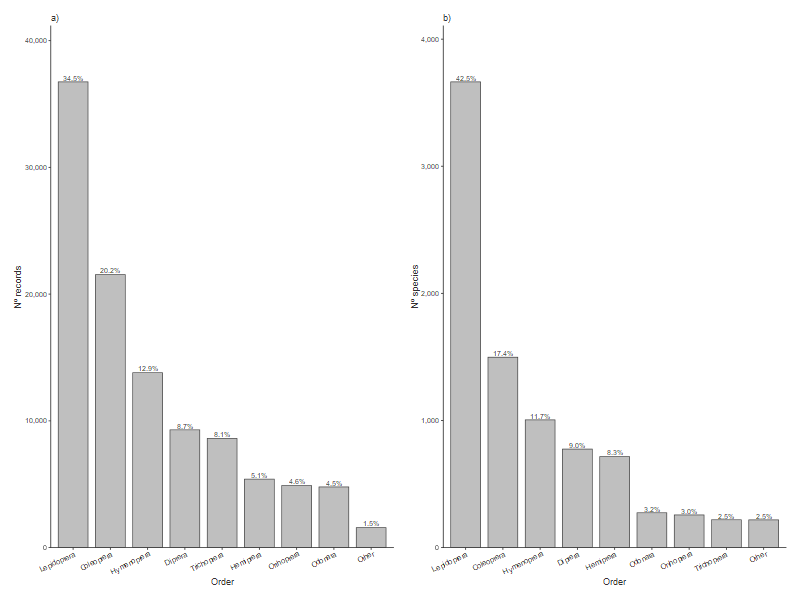

In [216]:

# -------------------------
# Registros: top 8 + Otro
# -------------------------
ord_rec_raw <- insects_pts_ecu |>
  count(order, name = "n_records") |>
  arrange(desc(n_records))

top8_rec <- ord_rec_raw |> slice_head(n = 8) |> pull(order)

ord_rec <- ord_rec_raw |>
  mutate(order_grp = if_else(order %in% top8_rec, order, "Other")) |>
  group_by(order_grp) |>
  summarise(n_records = sum(n_records), .groups = "drop") |>
  mutate(pct_records = 100 * n_records / sum(n_records)) |>
  arrange(desc(n_records)) |>
  mutate(order_grp = factor(order_grp, levels = c(top8_rec, "Other")[c(top8_rec, "Other") %in% order_grp]))

# -------------------------
# Especies únicas: top 8 + Otro
# -------------------------
ord_sp_raw <- insects_pts_ecu |>
  distinct(order, scientificName) |>
  count(order, name = "n_species") |>
  arrange(desc(n_species))

top8_sp <- ord_sp_raw |> slice_head(n = 8) |> pull(order)

ord_sp <- ord_sp_raw |>
  mutate(order_grp = if_else(order %in% top8_sp, order, "Other")) |>
  group_by(order_grp) |>
  summarise(n_species = sum(n_species), .groups = "drop") |>
  mutate(pct_species = 100 * n_species / sum(n_species)) |>
  arrange(desc(n_species)) |>
  mutate(order_grp = factor(order_grp, levels = c(top8_sp, "Other")[c(top8_sp, "Other") %in% order_grp]))

# ============================================================
# Estilo (idéntico a los gráficos anteriores)
# ============================================================
base_theme <- theme_classic(base_size = 9) +
  theme(
    axis.text  = element_text(color = "grey20"),
    axis.title = element_text(color = "grey20"),
    axis.line  = element_line(color = "grey20", linewidth = 0.4),
    axis.ticks = element_line(color = "grey20", linewidth = 0.4),
    plot.margin = margin(3, 3, 3, 3, "mm"),
    plot.title = element_text(color = "grey20", size = 8.5, hjust = 0)
  )

# a) Registros
reg_order<- ggplot(ord_rec, aes(x = order_grp, y = n_records)) +
  geom_col(fill = "grey75", color = "grey20", linewidth = 0.3, width = 0.8) +
  geom_text(aes(label = sprintf("%.1f%%", pct_records)),
            vjust = -0.25, size = 2.5, color = "grey20") +
  scale_y_continuous(labels = label_comma(accuracy = 1),
                     expand = expansion(mult = c(0, 0.12))) +
  labs(
    title = "a)",
    x = "Order",
    y = "Nº records"
  ) +
  base_theme +
  theme(axis.text.x = element_text(angle = 25, hjust = 1, vjust = 1))

# b) Especies
sp_order <- ggplot(ord_sp, aes(x = order_grp, y = n_species)) +
  geom_col(fill = "grey75", color = "grey20", linewidth = 0.3, width = 0.8) +
  geom_text(aes(label = sprintf("%.1f%%", pct_species)),
            vjust = -0.25, size = 2.5, color = "grey20") +
  scale_y_continuous(labels = label_comma(accuracy = 1),
                     expand = expansion(mult = c(0, 0.12))) +
  labs(
    title = "b)",
    x = "Order",
    y = "Nº species"
  ) +
  base_theme +
  theme(axis.text.x = element_text(angle = 25, hjust = 1, vjust = 1))

(reg_order | sp_order) + plot_layout(widths = c(1, 1))


## Distribution per Database

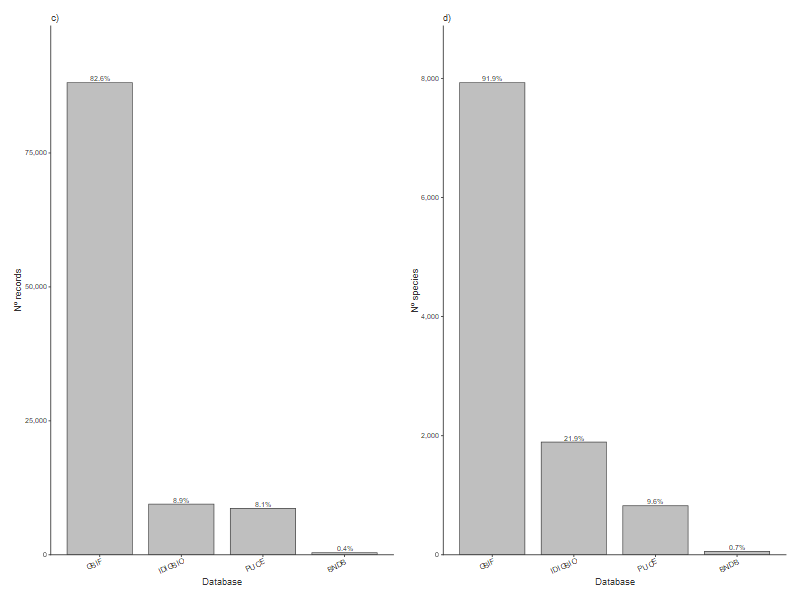

In [217]:
db_rec <- insects_pts_ecu |>
  count(database_name, name = "n_records") |>
  mutate(pct_records = 100 * n_records / sum(n_records)) |>
  arrange(desc(n_records)) |>
  mutate(database_name = factor(database_name, levels = database_name))

# -------------------------
# Especies únicas por base de datos
# Barra: n_species = especies únicas dentro del grupo (igual que antes)
# Porcentaje: respecto a riqueza global (S_global) del dataset
# -------------------------
S_global <- insects_pts_ecu |>
  distinct(scientificName) |>
  nrow()

db_sp <- insects_pts_ecu |>
  distinct(database_name, scientificName) |>
  count(database_name, name = "n_species") |>
  mutate(
    pct_species = 100 * n_species / S_global  # <-- cambio clave
  ) |>
  arrange(desc(n_species)) |>
  mutate(database_name = factor(database_name, levels = database_name))



# c) Registros por database_name
reg_database <- ggplot(db_rec, aes(x = database_name, y = n_records)) +
  geom_col(fill = "grey75", color = "grey20", linewidth = 0.3, width = 0.8) +
  geom_text(aes(label = sprintf("%.1f%%", pct_records)),
            vjust = -0.25, size = 2.5, color = "grey20") +
  scale_y_continuous(labels = label_comma(accuracy = 1),
                     expand = expansion(mult = c(0, 0.12))) +
  labs(
    title = "c)",
    x = "Database",
    y = "Nº records"
  ) +
  base_theme +
  theme(axis.text.x = element_text(angle = 25, hjust = 1, vjust = 1))

# d) Especies únicas por database_name
sp_database <- ggplot(db_sp, aes(x = database_name, y = n_species)) +
  geom_col(fill = "grey75", color = "grey20", linewidth = 0.3, width = 0.8) +
  geom_text(aes(label = sprintf("%.1f%%", pct_species)),
            vjust = -0.25, size = 2.5, color = "grey20") +
  scale_y_continuous(labels = label_comma(accuracy = 1),
                     expand = expansion(mult = c(0, 0.12))) +
  labs(
    title = "d)",
    x = "Database",
    y = "Nº species"
  ) +
  base_theme +
  theme(axis.text.x = element_text(angle = 25, hjust = 1, vjust = 1))

(reg_database | sp_database) + plot_layout(widths = c(1, 1))


## Dsitribution per Institution code

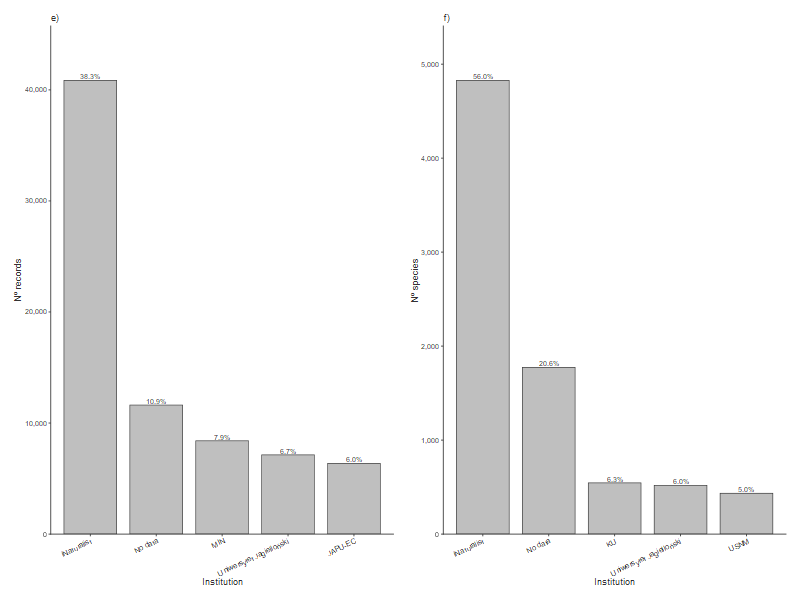

In [218]:


df <- insects_pts_ecu |>
  st_drop_geometry() |>
  mutate(
    institutionCode = if_else(is.na(institutionCode) | institutionCode == "", "No data", institutionCode),
    institutionCode = if_else(institutionCode == "Uniwersytet Jagiello?ski", "Uniwersytet Jagielloński", institutionCode)
  ) |>
  filter(!is.na(scientificName), scientificName != "")

# ============================================================
# 1) REGISTROS: calcular para todas, graficar top 5
#    pct_records = % del total de registros del dataset
# ============================================================
inst_rec_all <- df |>
  count(institutionCode, name = "n_records") |>
  mutate(pct_records = 100 * n_records / sum(n_records)) |>
  arrange(desc(n_records))

inst_rec_top5 <- inst_rec_all |>
  slice_head(n = 5) |>
  mutate(institutionCode = factor(institutionCode, levels = institutionCode))

# ============================================================
# 2) ESPECIES: calcular para todas, graficar top 5
#    Barra: n_species (especies únicas dentro del grupo)
#    pct_species = % de la riqueza global del dataset (S_global)
# ============================================================
S_global <- df |>
  distinct(scientificName) |>
  nrow()

inst_sp_all <- df |>
  distinct(institutionCode, scientificName) |>
  count(institutionCode, name = "n_species") |>
  mutate(pct_species = 100 * n_species / S_global) |>
  arrange(desc(n_species))

inst_sp_top5 <- inst_sp_all |>
  slice_head(n = 5) |>
  mutate(institutionCode = factor(institutionCode, levels = institutionCode))



# a) Top 5 instituciones por registros
reg_institution <- ggplot(inst_rec_top5, aes(x = institutionCode, y = n_records)) +
  geom_col(fill = "grey75", color = "grey20", linewidth = 0.3, width = 0.8) +
  geom_text(aes(label = sprintf("%.1f%%", pct_records)),
            vjust = -0.25, size = 2.5, color = "grey20") +
  scale_y_continuous(labels = label_comma(accuracy = 1),
                     expand = expansion(mult = c(0, 0.12))) +
  labs(
    title = "e)",
    x = "Institution",
    y = "Nº records"
  ) +
  base_theme +
  theme(axis.text.x = element_text(angle = 25, hjust = 1, vjust = 1))

# b) Top 5 instituciones por especies únicas
sp_institution <- ggplot(inst_sp_top5, aes(x = institutionCode, y = n_species)) +
  geom_col(fill = "grey75", color = "grey20", linewidth = 0.3, width = 0.8) +
  geom_text(aes(label = sprintf("%.1f%%", pct_species)),
            vjust = -0.25, size =2.5, color = "grey20") +
  scale_y_continuous(labels = label_comma(accuracy = 1),
                     expand = expansion(mult = c(0, 0.12))) +
  labs(
    title = "f)",
    x = "Institution",
    y = "Nº species"
  ) +
  base_theme +
  theme(axis.text.x = element_text(angle = 25, hjust = 1, vjust = 1))

(reg_institution | sp_institution) + plot_layout(widths = c(1, 1))



## Distribution per natural region

In [219]:
natural_regions_ecu <- st_intersection(natural_regions, ecu_u) %>% st_make_valid()
# Join por intersección (dentro)
pts_join_reg <- st_join(
  insects_pts_ecu,
  natural_regions_ecu,
  join = st_within,
  left = TRUE
)
# Identificar columnas "de región" (todas las de natural_regions excepto geometry)
reg_cols <- setdiff(names(natural_regions_ecu), attr(natural_regions_ecu, "sf_column"))

# Para los que quedaron sin región (NA en la primera col de región), asignar el más cercano
if (length(reg_cols) > 0) {
  na_idx <- is.na(st_drop_geometry(pts_join_reg)[[reg_cols[1]]])

  if (any(na_idx)) {
    nearest_id <- st_nearest_feature(pts_join_reg[na_idx, ], natural_regions_ecu)

    # Extraer atributos del polígono más cercano
    nearest_attrs <- st_drop_geometry(natural_regions_ecu[nearest_id, reg_cols, drop = FALSE])

    # Distancia al polígono más cercano (en metros aprox con S2 apagado; es una aproximación en 4326)
    # Si necesitas distancia geodésica exacta, deja sf_use_s2(TRUE) y recalcula.
    nearest_dist <- as.numeric(st_distance(pts_join_reg[na_idx, ], natural_regions_ecu[nearest_id, ], by_element = TRUE))

    # Rellenar atributos y guardar distancia + flag
    pts_join_reg[na_idx, reg_cols] <- nearest_attrs
    pts_join_reg$natural_region_assignment <- "within"
    pts_join_reg$natural_region_dist_to_nearest_m <- NA_real_
    pts_join_reg$natural_region_dist_to_nearest_m[na_idx] <- nearest_dist
    pts_join_reg$natural_region_assignment[na_idx] <- "nearest"
  } else {
    pts_join_reg$natural_region_assignment <- "within"
    pts_join_reg$natural_region_dist_to_nearest_m <- NA_real_
  }
} else {
  stop("No se detectaron columnas de atributos en natural_regions (solo geometry).")
}


Warning message:
attribute variables are assumed to be spatially constant throughout all geometries 


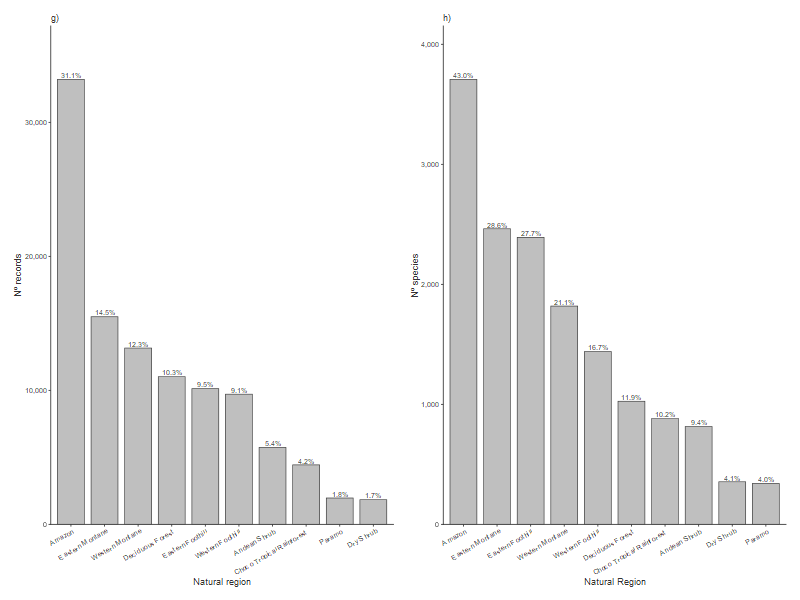

In [220]:


# -----------------------------------------------------------
# ============================================================
# 1) REGISTROS por tipo de vegetación
#    pct_records = % del total de registros del dataset
# ============================================================
veg_rec <- pts_join_reg |>
  count(veget, name = "n_records") |>
  mutate(pct_records = 100 * n_records / sum(n_records)) |>
  arrange(desc(n_records)) |>
  mutate(veget = factor(veget, levels = veget))

# ============================================================
# 2) ESPECIES por tipo de vegetación
#    Barra: n_species = especies únicas dentro de cada veget
#    Porcentaje: % de la riqueza global (S_global)
# ============================================================
S_global <- pts_join_reg |>
  distinct(scientificName) |>
  nrow()

veg_sp <- pts_join_reg |>
  distinct(veget, scientificName) |>
  count(veget, name = "n_species") |>
  mutate(pct_species = 100 * n_species / S_global) |>
  arrange(desc(n_species)) |>
  mutate(veget = factor(veget, levels = veget))


# ------------------------------------------------------------
# a) Registros por vegetación
# ------------------------------------------------------------
reg_natural_region <- ggplot(veg_rec, aes(x = veget, y = n_records)) +
  geom_col(fill = "grey75", color = "grey20", linewidth = 0.3, width = 0.8) +
  geom_text(aes(label = sprintf("%.1f%%", pct_records)),
            vjust = -0.25, size = 2.5, color = "grey20") +
  scale_y_continuous(
    labels = label_comma(accuracy = 1),
    expand = expansion(mult = c(0, 0.12))
  ) +
  labs(
    title = "g)",
    x = "Natural region",
    y = "Nº records"
  ) +
  base_theme +
  theme(axis.text.x = element_text(angle = 30, hjust = 1, vjust = 1))

# ------------------------------------------------------------
# b) Especies únicas por vegetación
# ------------------------------------------------------------
sp_natural_region <- ggplot(veg_sp, aes(x = veget, y = n_species)) +
  geom_col(fill = "grey75", color = "grey20", linewidth = 0.3, width = 0.8) +
  geom_text(aes(label = sprintf("%.1f%%", pct_species)),
            vjust = -0.25, size = 2.5, color = "grey20") +
  scale_y_continuous(
    labels = label_comma(accuracy = 1),
    expand = expansion(mult = c(0, 0.12))
  ) +
  labs(
    title = "h)",
    x = "Natural Region",
    y = "Nº species"
  ) +
  base_theme +
  theme(axis.text.x = element_text(angle = 30, hjust = 1, vjust = 1))

(reg_natural_region | sp_natural_region) + plot_layout(widths = c(1, 1))


## Distribution per SNAP

Warning message:
attribute variables are assumed to be spatially constant throughout all geometries 


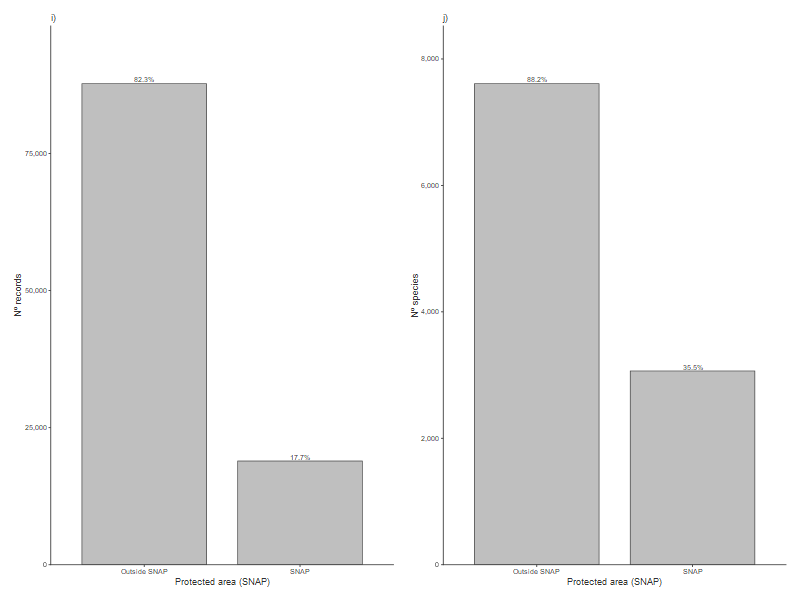

In [221]:
# =========================
# 6) Extraer info SNAP: dentro / fuera
# =========================
snap_ecu <- st_intersection(snap, ecu_u) %>% st_make_valid()
in_snap <- lengths(st_within(insects_pts_ecu, snap_ecu)) > 0
insects_pts_ecu$snap_in_out <- ifelse(in_snap, "SNAP", "Outside SNAP")


# ============================================================
# 1) REGISTROS por condición SNAP
#    pct_records = % del total de registros del dataset
# ============================================================
snap_rec <- insects_pts_ecu |>
  count(snap_in_out, name = "n_records") |>
  mutate(pct_records = 100 * n_records / sum(n_records)) |>
  arrange(desc(n_records)) |>
  mutate(snap_in_out = factor(snap_in_out, levels = snap_in_out))

# ============================================================
# 2) ESPECIES por condición SNAP
#    Barra: n_species = especies únicas dentro de cada grupo
#    Porcentaje: % de la riqueza global (S_global)
# ============================================================
S_global <- insects_pts_ecu |>
  distinct(scientificName) |>
  nrow()

snap_sp <- insects_pts_ecu |>
  distinct(snap_in_out, scientificName) |>
  count(snap_in_out, name = "n_species") |>
  mutate(pct_species = 100 * n_species / S_global) |>
  arrange(desc(n_species)) |>
  mutate(snap_in_out = factor(snap_in_out, levels = snap_in_out))


# ------------------------------------------------------------
# a) Registros dentro / fuera de SNAP
# ------------------------------------------------------------
reg_snap <- ggplot(snap_rec, aes(x = snap_in_out, y = n_records)) +
  geom_col(fill = "grey75", color = "grey20", linewidth = 0.3, width = 0.8) +
  geom_text(aes(label = sprintf("%.1f%%", pct_records)),
            vjust = -0.25, size =2.5, color = "grey20") +
  scale_y_continuous(
    labels = label_comma(accuracy = 1),
    expand = expansion(mult = c(0, 0.12))
  ) +
  labs(
    title = "i)",
    x = "Protected area (SNAP)",
    y = "Nº records"
  ) +
  base_theme

# ------------------------------------------------------------
# b) Especies únicas dentro / fuera de SNAP
# ------------------------------------------------------------
sp_snap <- ggplot(snap_sp, aes(x = snap_in_out, y = n_species)) +
  geom_col(fill = "grey75", color = "grey20", linewidth = 0.3, width = 0.8) +
  geom_text(aes(label = sprintf("%.1f%%", pct_species)),
            vjust = -0.25, size = 2.5, color = "grey20") +
  scale_y_continuous(
    labels = label_comma(accuracy = 1),
    expand = expansion(mult = c(0, 0.12))
  ) +
  labs(
    title = "j)",
    x = "Protected area (SNAP)",
    y = "Nº species"
  ) +
  base_theme

(reg_snap | sp_snap) + plot_layout(widths = c(1, 1))


## Export plot

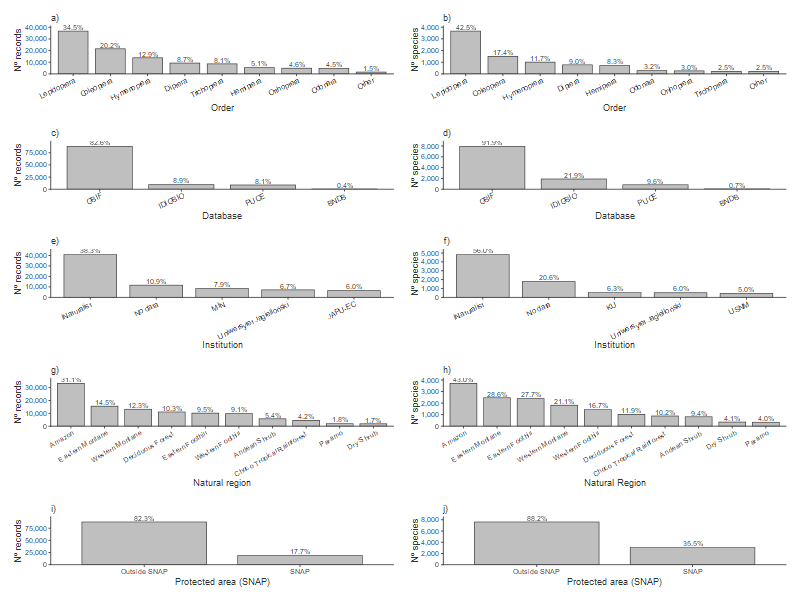

In [222]:
plots <- list(reg_order, sp_order,
  reg_database, sp_database,
  reg_institution, sp_institution,
  reg_natural_region, sp_natural_region,
  reg_snap, sp_snap)

wrap_plots = wrap_plots(plots, ncol = 2) 
wrap_plots

In [223]:
ggsave(
  filename = "Results/Reports/Plots/records_distribution.png",
  plot     = wrap_plots,
  width    = 180, height = 225, units = "mm",
  dpi      = 600, bg = "white"
)


## Export dataset

Order

In [224]:
order_summary = ord_rec_raw   %>% left_join(ord_sp_raw, by = c("order")) %>%as.data.frame()%>%dplyr::select(-geometry)
order_summary$Percentaje_records = (order_summary$n_records/ sum(order_summary$n_records))*100
order_summary$Percentaje_sp= (order_summary$n_species/ sum(order_summary$n_species))*100
order_summary = order_summary%>% dplyr::select(order, n_records,Percentaje_records,   n_species, Percentaje_sp)
colnames(order_summary) = c("Order",  "Total Records", "Percentage of Records", "Total Species", "Percentage of Species from the total")
head(order_summary, 5)

        Order Total Records Percentage of Records Total Species
1 Lepidoptera         36748             34.456311          3664
2  Coleoptera         21540             20.196716          1498
3 Hymenoptera         13799             12.938463          1005
4     Diptera          9291              8.711592           775
5 Trichoptera          8614              8.076811           219
  Percentage of Species from the total
1                            42.476235
2                            17.366102
3                            11.650823
4                             8.984466
5                             2.538836

Database

In [225]:
db_summary = db_rec   %>% left_join(db_sp, by = c("database_name")) %>%as.data.frame()%>%dplyr::select(-geometry)
colnames(db_summary) = c("Database", "Total Records", "Percentage of Records", "Total Species", "Percentage of Species from the total")
head(db_summary, 5)

  Database Total Records Percentage of Records Total Species
1     GBIF         88135            82.6387001          7929
2  IDIGBIO          9463             8.8728657          1893
3     PUCE          8662             8.1218179           824
4     BNDB           391             0.3666163            57
  Percentage of Species from the total
1                            91.919777
2                            21.945282
3                             9.552516
4                             0.660793

Institution

In [226]:
inst_summary =  inst_rec_all   %>% left_join(inst_sp_all, by = c("institutionCode"))
colnames(inst_summary) = c("Institution Code", "Total Records", "Percentage of Records", "Total Species", "Percentage of Species from the total")
head(inst_summary, 5)

          Institution Code Total Records Percentage of Records Total Species
1              iNaturalist         40853             38.305314          4827
2                  No data         11621             10.896288          1774
3                      MIN          8398              7.874282           186
4 Uniwersytet Jagielloński          7132              6.687232           519
5                  JAPU-EC          6365              5.968064            44
  Percentage of Species from the total
1                           55.9587294
2                           20.5657315
3                            2.1562717
4                            6.0166937
5                            0.5100858

Natural region

In [227]:
veg_summary = veg_rec%>% left_join(veg_sp, by = c("veget")) %>%as.data.frame()%>%dplyr::select(-geometry)
colnames(veg_summary) = c("Natural Region", "Total Records", "Percentage of Records", "Total Species", "Percentage of Species from the total")
head(veg_summary, 5)

    Natural Region Total Records Percentage of Records Total Species
1           Amazon         33211             31.118878          3708
2  Eastern Montane         15496             14.519832          2463
3  Western Montane         13160             12.330988          1819
4 Deciduous Forest         11025             10.330482          1026
5 Eastern Foothill         10127              9.489051          2391
  Percentage of Species from the total
1                             42.98632
2                             28.55321
3                             21.08741
4                             11.89427
5                             27.71853

SNAP

In [228]:
snap_summary =  snap_rec%>% left_join(snap_sp, by = c("snap_in_out"))%>%as.data.frame()%>%dplyr::select(-geometry)
colnames(snap_summary) = c("SNAP", "Total Records", "Percentage of Records", "Total Species", "Percentage of Species from the total")
head(snap_summary, 5)

          SNAP Total Records Percentage of Records Total Species
1 Outside SNAP         87734              82.26271          7609
2         SNAP         18917              17.73729          3065
  Percentage of Species from the total
1                             88.21006
2                             35.53211

Export

In [229]:
# -------------------------
# Crear workbook y hojas
# -------------------------
wb <- createWorkbook()

addWorksheet(wb, "order_summary")
writeData(wb, sheet = "order_summary", x = order_summary)

addWorksheet(wb, "db_summary")
writeData(wb, sheet = "db_summary", x = db_summary)

addWorksheet(wb, "inst_summary")
writeData(wb, sheet = "inst_summary", x = inst_summary)

addWorksheet(wb, "veg_summary")
writeData(wb, sheet = "veg_summary", x = veg_summary)

addWorksheet(wb, "snap_summary")
writeData(wb, sheet = "snap_summary", x = snap_summary)


out_file <- "Results/Reports/excels/distribution_data_report.xlsx"

saveWorkbook(wb, file = out_file, overwrite = TRUE)

# Maps

## Sampling completness

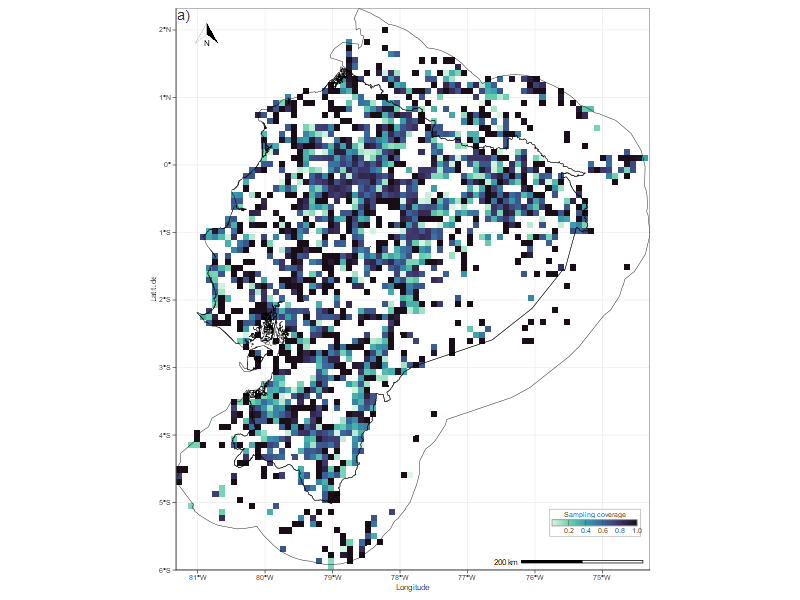

In [230]:
# ----------------------------
# 1) Preparación de datos
# ----------------------------
sampling_effort <- st_make_valid(sampling_effort) |> st_transform(4326)
sampling_effort$Smplg_c <- as.numeric(sampling_effort$Smplg_c)
sampling_effort_ecu <- sampling_effort |> filter(!is.na(Smplg_c))

# ----------------------------
# 2) Tema base (sin saturar)
# ----------------------------
base_theme <- theme_classic(base_size = 9) +
  theme(
    text = element_text(color = "grey20"),
    axis.text  = element_text(color = "grey20", size = 7),
    axis.title = element_text(color = "grey20", size = 7.5),

    axis.line  = element_line(color = "grey25", linewidth = 0.35),
    axis.ticks = element_line(color = "grey25", linewidth = 0.35),
    axis.ticks.length = unit(1.2, "mm"),

    panel.grid.major = element_line(color = "grey90", linewidth = 0.25),
    panel.grid.minor = element_blank(),

    panel.background = element_rect(fill = "white", colour = NA),
    plot.background  = element_rect(fill = "white", colour = NA),

    panel.border = element_rect(color = "grey30", fill = NA, linewidth = 0.4),

    # margen uniforme
    plot.margin = margin(3, 3, 3, 3, "mm")
  )

# ----------------------------
# 3) Leyenda compacta (sin recorte de etiquetas)
# ----------------------------
compact_legend <- list(
  guides(
    fill = guide_colorbar(
      title.position = "top",
      title.hjust = 0.5,
      label.position = "bottom",
      label.hjust = 0.5,
      barwidth  = unit(30, "mm"),
      barheight = unit(2.2, "mm"),
      ticks.colour = "grey25",
      frame.colour = "grey60"
    )
  ),
  theme(
    legend.position = c(0.98, 0.06),
    legend.justification = c(1, 0),
    legend.direction = "horizontal",

    legend.title = element_text(size = 6.5, margin = margin(b = 0.6, unit = "mm")),
    legend.text  = element_text(size = 6.6, margin = margin(t = 0.6, r = 1.0, l = 1.0, unit = "mm")),

    legend.key.height = unit(2.0, "mm"),
    legend.key.width  = unit(9, "mm"),

    legend.margin = margin(0.8, 1.2, 0.8, 0.8, "mm"),
    legend.background = element_rect(
      fill = alpha("white", 0.85),
      color = "grey60",
      linewidth = 0.25
    )
  )
)

# ----------------------------
# 4) Mapa A) completo
# (requiere objetos: ecu, buffer)
# ----------------------------
mapa_sampling_complete <- ggplot() +
  geom_sf(
    data = sampling_effort_ecu,
    aes(fill = Smplg_c),
    color = NA
  ) +
  geom_sf(data = ecu, fill = NA, color = "black", size = 0.2) +
  geom_sf(data = buffer, fill = NA, color = "black", size = 0.2) +
  scale_fill_viridis_c(
    option = "mako",
    direction = -1,
    begin = 0.05,
    end = 1,
    na.value = "transparent",
    breaks = c(0.2, 0.4, 0.6,  0.8, 1.00),
    labels = label_number(accuracy = 0.1)
  ) +
  annotation_north_arrow(
    location = "tl", which_north = "true",
    pad_x = unit(0.27, "in"), pad_y = unit(0.2, "in"),
    height = unit(0.8, "cm"), width = unit(0.8, "cm"),
    style = north_arrow_orienteering(line_width = 0.2, text_size = 5.8)
  ) +
  annotation_scale(location = "br", width_hint = 0.28, height = unit(0.09, "cm")) +
  coord_sf(expand = FALSE) +
  theme_minimal() +
  base_theme +
  compact_legend +
  labs(
    title = NULL,
    fill = "Sampling coverage",
    x = "Longitude",
    y = "Latitude"
  ) +
  annotate(
    "text",
    x = -Inf, y = Inf,
    label = "a)",
    hjust = -0.1, vjust = 1.1,
    size = 5,
    color = "grey20"
  )

mapa_sampling_complete


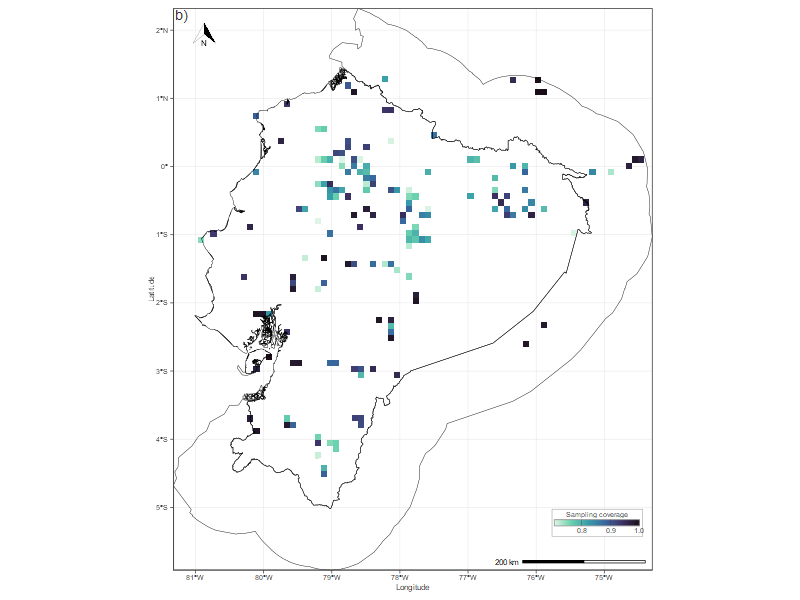

In [231]:

# ----------------------------
# 1) Preparación de datos
# ----------------------------
sampling_filter <- st_make_valid(sampling_filter) |> st_transform(4326)
sampling_filter$Smplg_c <- as.numeric(sampling_filter$Smplg_c)
sampling_effort_filter_ecu <- sampling_filter |> filter(!is.na(Smplg_c))
# ----------------------------
# 4) Mapa filtrado
#    (mismo FIX de título + leyenda interna)
# ----------------------------
# Ajuste de leyenda para el mapa b) (evita recorte de etiquetas, incluido 1.00)
# ----------------------------
# 4) Mapa B) filtrado
# (requiere objetos: ecu, buffer)
# ----------------------------
mapa_sampling_filter <- ggplot() +
  geom_sf(
    data = sampling_effort_filter_ecu,
    aes(fill = Smplg_c),
    color = NA
  ) +
  geom_sf(data = ecu, fill = NA, color = "black", size = 0.2) +
  geom_sf(data = buffer, fill = NA, color = "black", size = 0.2) +
  scale_fill_viridis_c(
    option = "mako",
    direction = -1,
    begin = 0.05,
    end = 1,
    na.value = "transparent",
    breaks = c(0.7, 0.8, 0.9,  1.00),
    labels = label_number(accuracy = 0.1)
  ) +
    annotation_north_arrow(
      location = "tl", which_north = "true",
      pad_x = unit(0.27, "in"), pad_y = unit(0.2, "in"),
      height = unit(0.8, "cm"), width = unit(0.8, "cm"),
      style = north_arrow_orienteering(line_width = 0.2, text_size = 5.8)
    )  +
  annotation_scale(location = "br", width_hint = 0.28, height = unit(0.09, "cm")) +
  coord_sf(expand = FALSE) +
  theme_minimal() +
  base_theme +
  compact_legend +
  labs(
    title = NULL,
    fill = "Sampling coverage",
    x = "Longitude",
    y = "Latitude"
  ) +
  annotate(
    "text",
    x = -Inf, y = Inf,
    label = "b)",
    hjust = -0.1, vjust = 1.1,
    size = 5,
    color = "grey20"
  )

mapa_sampling_filter




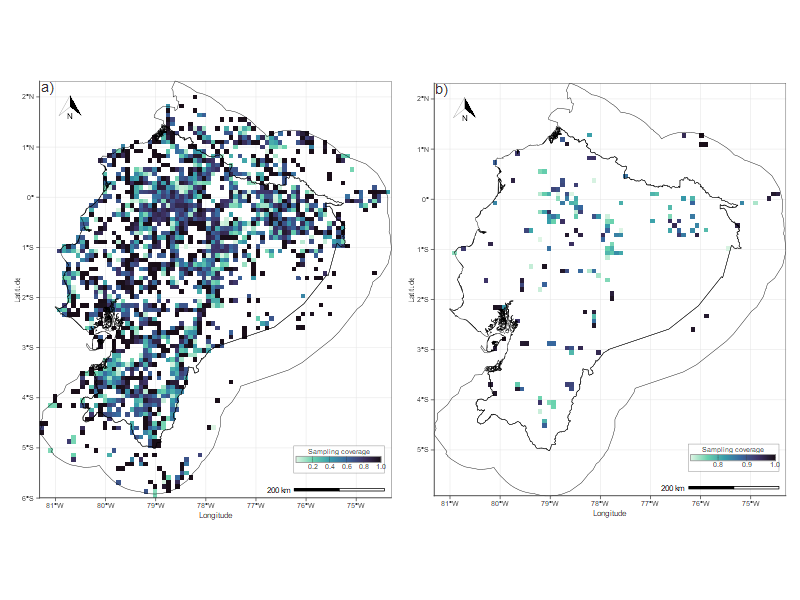

In [232]:

maps_sampling_coverage =  (mapa_sampling_complete | mapa_sampling_filter) +
  plot_layout(widths = c(1, 1))

maps_sampling_coverage

In [233]:
ggsave(
  filename = "Results/Reports/Plots/sampling_coverage_map.png",
  plot     = maps_sampling_coverage,
  width    = 180, height = 190, units = "mm",
  dpi      = 600, bg = "white"
)


In [234]:
len_total_grid = dim(sampling_effort)[1]
len_data_sampling = dim(sampling_effort_ecu)[1]
len_data_sampling_filter = dim(sampling_filter)[1]

cat("Dim total grid: ", len_total_grid, "Dim grid with sampling complt data: ", len_data_sampling, "Dim grid with sampling complt data and filtered: ", len_data_sampling_filter)


Dim total grid:  7268 Dim grid with sampling complt data:  1712 Dim grid with sampling complt data and filtered:  162

In [235]:
percent_total_grid = 100
percent_total_sampling = (percent_total_grid*len_data_sampling)/len_total_grid
percent_data_sampling_filter = (percent_total_grid*len_data_sampling_filter)/len_total_grid

cat("% total grid: ", percent_total_grid, "% grid with sampling complt data: ", percent_total_sampling, "% grid with sampling complt data and filtered: ", percent_data_sampling_filter)

% total grid:  100 % grid with sampling complt data:  23.55531 % grid with sampling complt data and filtered:  2.228949

In [236]:
summary(sampling_effort$Smplg_c)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.006   0.456   0.708   0.678   1.000   1.000    5556 

In [237]:
summary(sampling_filter$Smplg_c)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.7047  0.7900  0.8740  0.8656  0.9450  1.0000 

## Richness, Endemism, Density, knowledge Gaps

### Richness

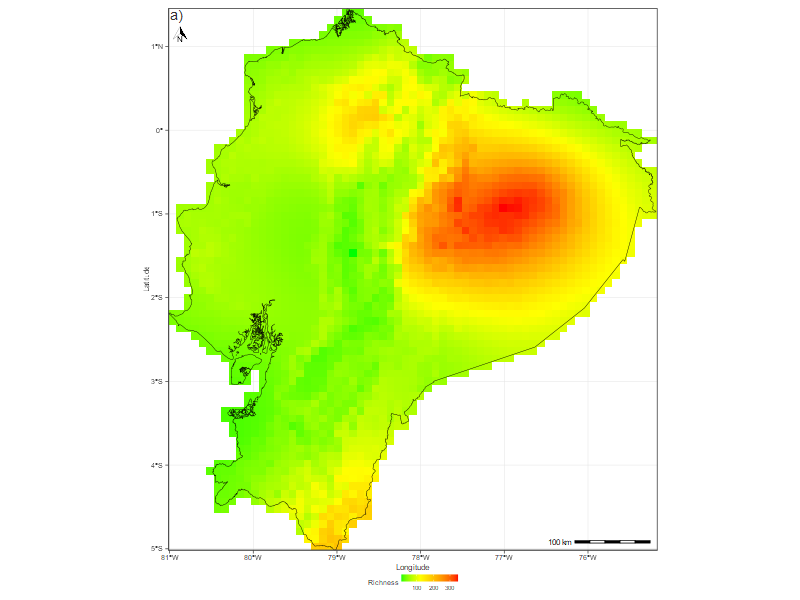

In [238]:

compact_legend <- theme(
  legend.position = "bottom",
  legend.key.size = unit(0.3, "cm"),        # Reduce el tamaño de las keys
  legend.key.width = unit(0.8, "cm"),       # Ancho de la barra de leyenda
  legend.key.height = unit(0.25, "cm"),     # Alto de la barra de leyenda
  legend.title = element_text(size = 7),     # Tamaño del título
  legend.text = element_text(size = 6),      # Tamaño del texto
  legend.margin = margin(t = 0, r = 0, b = 0, l = 0),  # Reduce márgenes
  legend.box.spacing = unit(0.1, "cm")       # Espacio entre leyenda y plot
)

alpha_div_df <- as.data.frame(rasterToPoints(raster(alpha_div)))
colnames(alpha_div_df) <- c("longitud", "latitud", "valor")


# Convertir los valores de "valor" a numéricos para poder usar un gradiente continuo
alpha_div_df$valor <- as.numeric(alpha_div_df$valor)

mapa_alpha <-  ggplot(alpha_div_df %>% filter(!is.na(valor))) +
  # Añadir la capa de datos clasificada con gradiente continuo
  geom_tile(aes(x = longitud, y = latitud, fill = valor))+
 
  geom_sf(data = ecu, fill = NA, color = "black", size = 0.2) +
    scale_fill_gradientn(
      colours = c("green", "yellow", "orange", "red"),  # Definir el gradiente
      na.value = "transparent"  # Manejar valores NA
    ) +
  annotation_north_arrow(
    location = "tl", which_north = "true",
    pad_x = unit(0.06, "in"), pad_y = unit(0.25, "in"),
    height = unit(0.5, "cm"), width = unit(0.5, "cm"),
    style = north_arrow_orienteering(line_width = 0.2, text_size = 5.8)
  ) + guides(fill = guide_colorbar(barwidth = unit(2, "cm"))) +
  annotation_scale(location = "br", width_hint = 0.28, height = unit(0.09, "cm")) +
  coord_sf(expand = FALSE) +
  theme_minimal() +
  base_theme +
  compact_legend +
  labs(
    title = NULL,
    fill = "Richness",
    x = "Longitude",
    y = "Latitude"
  ) +
  annotate(
    "text",
    x = -Inf, y = Inf,
    label = "a)",
    hjust = -0.1, vjust = 1.1,
    size = 5,
    color = "grey20"
  )

mapa_alpha

### Endemism

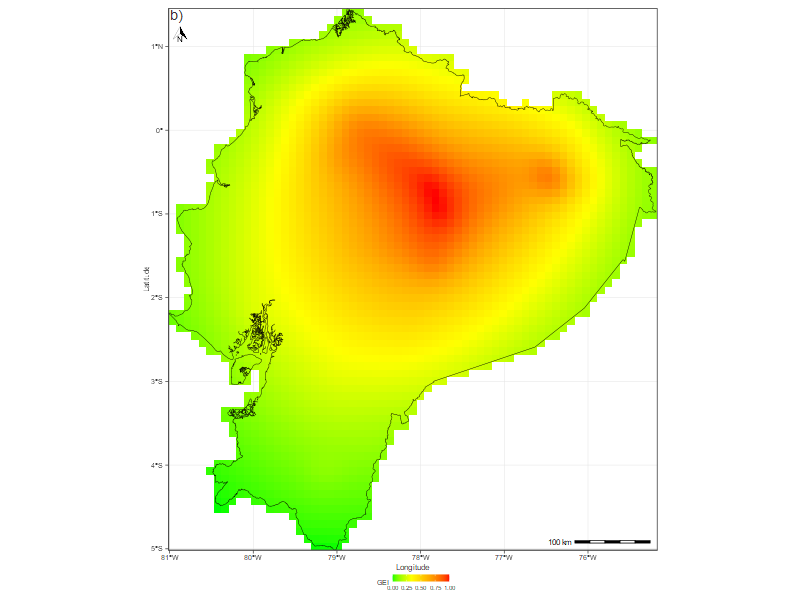

In [239]:
endemism_df <- as.data.frame(rasterToPoints(raster(endemism)))
colnames(endemism_df) <- c("longitud", "latitud", "valor")


# Convertir los valores de "valor" a numéricos para poder usar un gradiente continuo
endemism_df$valor <- as.numeric(endemism_df$valor)

mapa_endemism <-  ggplot(endemism_df %>% filter(!is.na(valor))) +
  # Añadir la capa de datos clasificada con gradiente continuo
  geom_tile(aes(x = longitud, y = latitud, fill = valor))+
 
  geom_sf(data = ecu, fill = NA, color = "black", size = 0.2) +
    scale_fill_gradientn(
      colours = c("green", "yellow", "orange", "red"),  # Definir el gradiente
      na.value = "transparent"  # Manejar valores NA
    ) +
      annotation_north_arrow(
        location = "tl", which_north = "true",
        pad_x = unit(0.06, "in"), pad_y = unit(0.25, "in"),
        height = unit(0.5, "cm"), width = unit(0.5, "cm"),
        style = north_arrow_orienteering(line_width = 0.2, text_size = 5.8)
      ) + guides(fill = guide_colorbar(barwidth = unit(2, "cm"))) +
  annotation_scale(location = "br", width_hint = 0.28, height = unit(0.09, "cm")) +
  coord_sf(expand = FALSE) +
  theme_minimal() +
  base_theme +
  compact_legend +
  labs(
    title = NULL,
    fill = "GEI",
    x = "Longitude",
    y = "Latitude"
  ) +
  annotate(
    "text",
    x = -Inf, y = Inf,
    label = "b)",
    hjust = -0.1, vjust = 1.1,
    size = 5,
    color = "grey20"
  )

mapa_endemism

### Density

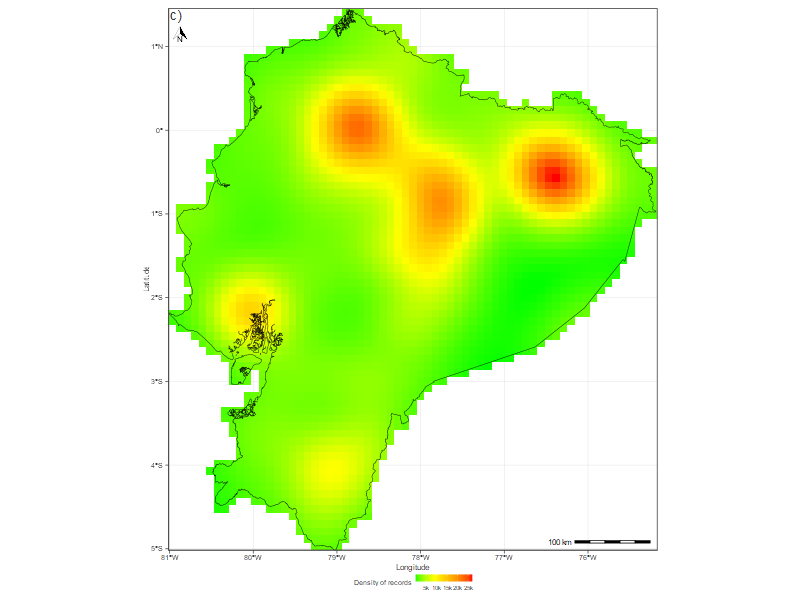

In [240]:
density_df <- as.data.frame(rasterToPoints(raster(density)))
colnames(density_df) <- c("longitud", "latitud", "valor")

# Convertir los valores de "valor" a numéricos para poder usar un gradiente continuo
density_df$valor <- as.numeric(density_df$valor)

mapa_density <-  ggplot(density_df %>% filter(!is.na(valor))) +
  # Añadir la capa de datos clasificada con gradiente continuo
  geom_tile(aes(x = longitud, y = latitud, fill = valor))+
 
  geom_sf(data = ecu, fill = NA, color = "black", size = 0.2) +
  scale_fill_gradientn(
    colours = c("green", "yellow", "orange", "red"),  # Definir el gradiente
    na.value = "transparent",  # Manejar valores NA
    labels = function(x) paste0(x/1000, "k")  # Convertir a miles con "k"
  ) +
    annotation_north_arrow(
      location = "tl", which_north = "true",
      pad_x = unit(0.06, "in"), pad_y = unit(0.25, "in"),
      height = unit(0.5, "cm"), width = unit(0.5, "cm"),
      style = north_arrow_orienteering(line_width = 0.2, text_size = 5.8)
    ) + guides(fill = guide_colorbar(barwidth = unit(2, "cm"))) +
  annotation_scale(location = "br", width_hint = 0.28, height = unit(0.09, "cm")) +
  coord_sf(expand = FALSE) +
  theme_minimal() +
  base_theme +
  compact_legend +
  labs(
    title = NULL,
    fill = "Density of records",
    x = "Longitude",
    y = "Latitude"
  ) +
  annotate(
    "text",
    x = -Inf, y = Inf,
    label = "c)",
    hjust = -0.1, vjust = 1.1,
    size = 5,
    color = "grey20"
  )

mapa_density

### KG - Richness

 Factor w/ 5 levels "1","2","3","4",..: 3 3 3 3 3 3 3 3 3 3 ...


Warning message:
Removed 1 row containing missing values or values outside the scale range
(`geom_tile()`). 


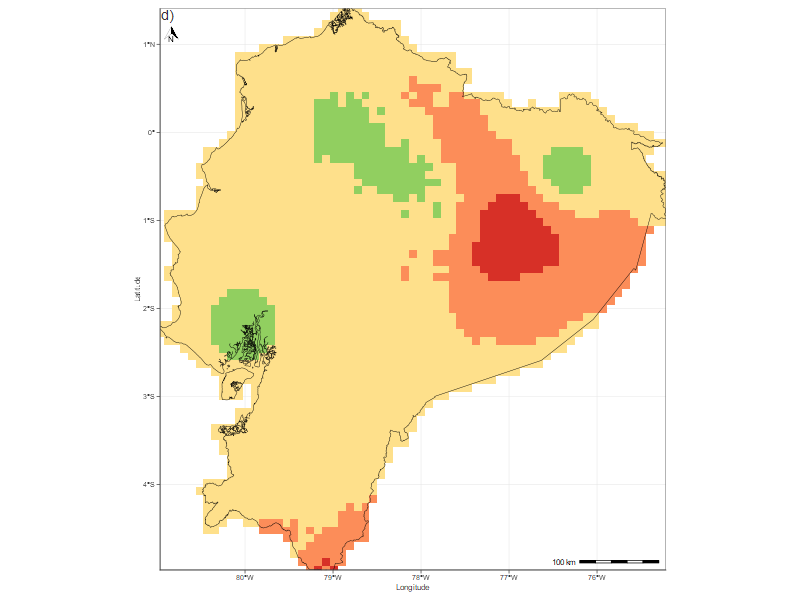

In [241]:
alpha_kg_likert_df <- as.data.frame(rasterToPoints(raster(alpha_kg_likert)))
colnames(alpha_kg_likert_df) <- c("longitud", "latitud", "valor")

# Likert discreto (1–5) con orden explícito
alpha_kg_likert_df <- alpha_kg_likert_df |>
  dplyr::filter(!is.na(valor)) |>
  dplyr::mutate(
    valor = factor(valor,
                   levels = c(1, 2, 3, 4, 5),
                   labels = c("1", "2", "3", "4", "5"),
                   ordered = TRUE)
  )

# SOLUCIÓN: Guardar los límites originales ANTES de agregar dummies
lon_limits <- range(alpha_kg_likert_df$longitud)
lat_limits <- range(alpha_kg_likert_df$latitud)

# Agregar filas dummy para niveles faltantes
niveles_faltantes <- setdiff(c("1", "2", "3", "4", "5"), 
                              unique(as.character(alpha_kg_likert_df$valor)))

if(length(niveles_faltantes) > 0) {
  dummy_rows <- data.frame(
    longitud = rep(NA, length(niveles_faltantes)),  # Usar NA en lugar de coordenadas lejanas
    latitud = rep(NA, length(niveles_faltantes)),
    valor = factor(niveles_faltantes, levels = c("1", "2", "3", "4", "5"))
  )
  
  alpha_kg_likert_df <- rbind(alpha_kg_likert_df, dummy_rows)
}

# Verificar
str(alpha_kg_likert_df$valor)
table(alpha_kg_likert_df$valor, useNA = "always")

mapa_alpha_kg_likert <- ggplot(alpha_kg_likert_df) +
  geom_tile(aes(x = longitud, y = latitud, fill = valor),show.legend = FALSE) +
  geom_sf(data = ecu, fill = NA, color = "black", size = 0.2) +
  scale_fill_manual(
    values = c("1" = "#1a9850",  # verde
               "2" = "#91cf60",
               "3" = "#fee08b",  # amarillo
               "4" = "#fc8d59",
               "5" = "#d73027"), # rojo
    drop = FALSE,
    na.value = "transparent",
    name = "Knowledge importance"
  ) +
  annotation_north_arrow(
    location = "tl", which_north = "true",
    pad_x = unit(0.06, "in"), pad_y = unit(0.25, "in"),
    height = unit(0.5, "cm"), width = unit(0.5, "cm"),
    style = north_arrow_orienteering(line_width = 0.2, text_size = 5.8)
  ) +
  annotation_scale(location = "br", width_hint = 0.28, height = unit(0.09, "cm")) +
  coord_sf(xlim = lon_limits, ylim = lat_limits, expand = FALSE) +  # Forzar límites originales
  theme_minimal() +
  base_theme +
  compact_legend +
  guides(
    fill = guide_legend(
      nrow = 1,
      keywidth = unit(0.4, "cm"),
      keyheight = unit(0.3, "cm"),
      title.position = "top",
      title.hjust = 0.5
    )
  ) +
  labs(
    title = NULL,
    x = "Longitude",
    y = "Latitude"
  ) +
  annotate(
    "text",
    x = -Inf, y = Inf,
    label = "d)",
    hjust = -0.1, vjust = 1.1,
    size = 5,
    color = "grey20"
  )

mapa_alpha_kg_likert

### KG - Endemism

 Factor w/ 5 levels "1","2","3","4",..: 3 3 3 3 3 3 3 3 3 3 ...


Warning message:
Removed 2 rows containing missing values or values outside the scale range
(`geom_tile()`). 


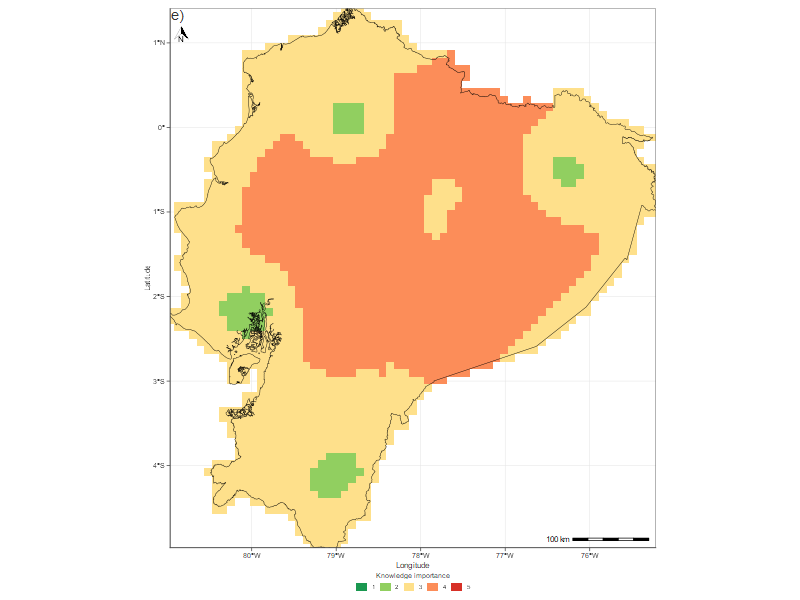

In [242]:
endemism_kg_likert_df <- as.data.frame(rasterToPoints(raster(endemism_kg_likert)))
colnames(endemism_kg_likert_df) <- c("longitud", "latitud", "valor")

# Likert discreto (1–5) con orden explícito
endemism_kg_likert_df <- endemism_kg_likert_df |>
  dplyr::filter(!is.na(valor)) |>
  dplyr::mutate(
    valor = factor(valor,
                   levels = c(1, 2, 3, 4, 5),
                   labels = c("1", "2", "3", "4", "5"),
                   ordered = TRUE)
  )

# SOLUCIÓN: Guardar los límites originales ANTES de agregar dummies
lon_limits <- range(endemism_kg_likert_df$longitud)
lat_limits <- range(endemism_kg_likert_df$latitud)

# Agregar filas dummy para niveles faltantes
niveles_faltantes <- setdiff(c("1", "2", "3", "4", "5"), 
                              unique(as.character(endemism_kg_likert_df$valor)))

if(length(niveles_faltantes) > 0) {
  dummy_rows <- data.frame(
    longitud = rep(NA, length(niveles_faltantes)),
    latitud = rep(NA, length(niveles_faltantes)),
    valor = factor(niveles_faltantes, levels = c("1", "2", "3", "4", "5"))
  )
  
  endemism_kg_likert_df <- rbind(endemism_kg_likert_df, dummy_rows)
}

# Verificar que la columna 'valor' sea factor
str(endemism_kg_likert_df$valor)
table(endemism_kg_likert_df$valor, useNA = "always")

mapa_endemism_kg_likert <- ggplot(endemism_kg_likert_df) +
  geom_tile(aes(x = longitud, y = latitud, fill = valor)) +
  geom_sf(data = ecu, fill = NA, color = "black", size = 0.2) +
  scale_fill_manual(
    values = c("1" = "#1a9850",  # verde
               "2" = "#91cf60",
               "3" = "#fee08b",  # amarillo
               "4" = "#fc8d59",
               "5" = "#d73027"), # rojo
    drop = FALSE,
    na.value = "transparent",
    name = "Knowledge importance"
  ) +
  annotation_north_arrow(
    location = "tl", which_north = "true",
    pad_x = unit(0.06, "in"), pad_y = unit(0.25, "in"),
    height = unit(0.5, "cm"), width = unit(0.5, "cm"),
    style = north_arrow_orienteering(line_width = 0.2, text_size = 5.8)
  ) +
  annotation_scale(location = "br", width_hint = 0.28, height = unit(0.09, "cm")) +
  coord_sf(xlim = lon_limits, ylim = lat_limits, expand = FALSE) +
  theme_minimal() +
  base_theme +
  compact_legend +
  guides(
    fill = guide_legend(
      nrow = 1,
      keywidth = unit(0.4, "cm"),
      keyheight = unit(0.3, "cm"),
      title.position = "top",
      title.hjust = 0.5
    )
  ) +
  labs(
    title = NULL,
    x = "Longitude",
    y = "Latitude"
  ) +
  annotate(
    "text",
    x = -Inf, y = Inf,
    label = "e)",
    hjust = -0.1, vjust = 1.1,
    size = 5,
    color = "grey20"
  )

mapa_endemism_kg_likert

### KG - Richness/Endemism

 Factor w/ 5 levels "1","2","3","4",..: 2 2 2 2 2 2 2 2 2 2 ...


Warning message:
Removed 1 row containing missing values or values outside the scale range
(`geom_tile()`). 


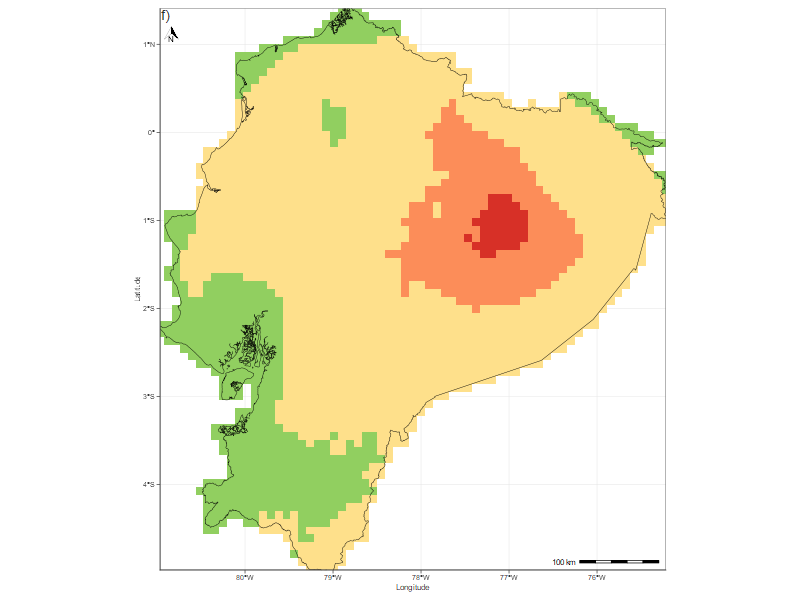

In [243]:
alpha_endemism_kg_likert_df <- as.data.frame(rasterToPoints(raster(alpha_endemism_kg_likert)))
colnames(alpha_endemism_kg_likert_df) <- c("longitud", "latitud", "valor")

# Likert discreto (1–5) con orden explícito
alpha_endemism_kg_likert_df <- alpha_endemism_kg_likert_df |>
  dplyr::filter(!is.na(valor)) |>
  dplyr::mutate(
    valor = factor(valor,
                   levels = c(1, 2, 3, 4, 5),
                   labels = c("1", "2", "3", "4", "5"),
                   ordered = TRUE)
  )

# SOLUCIÓN: Guardar los límites originales ANTES de agregar dummies
lon_limits <- range(alpha_endemism_kg_likert_df$longitud)
lat_limits <- range(alpha_endemism_kg_likert_df$latitud)

# Agregar filas dummy para niveles faltantes
niveles_faltantes <- setdiff(c("1", "2", "3", "4", "5"), 
                              unique(as.character(alpha_endemism_kg_likert_df$valor)))

if(length(niveles_faltantes) > 0) {
  dummy_rows <- data.frame(
    longitud = rep(NA, length(niveles_faltantes)),
    latitud = rep(NA, length(niveles_faltantes)),
    valor = factor(niveles_faltantes, levels = c("1", "2", "3", "4", "5"))
  )
  
  alpha_endemism_kg_likert_df <- rbind(alpha_endemism_kg_likert_df, dummy_rows)
}

# Verificar que la columna 'valor' sea factor
str(alpha_endemism_kg_likert_df$valor)
table(alpha_endemism_kg_likert_df$valor, useNA = "always")

mapa_alpha_endemism_kg_likert <- ggplot(alpha_endemism_kg_likert_df) +
  geom_tile(aes(x = longitud, y = latitud, fill = valor), show.legend = FALSE) +
  geom_sf(data = ecu, fill = NA, color = "black", size = 0.2) +
  scale_fill_manual(
    values = c("1" = "#1a9850",  # verde
               "2" = "#91cf60",
               "3" = "#fee08b",  # amarillo
               "4" = "#fc8d59",
               "5" = "#d73027"), # rojo
    drop = FALSE,
    na.value = "transparent",
    name = "Knowledge importance"
  ) +
  annotation_north_arrow(
    location = "tl", which_north = "true",
    pad_x = unit(0.06, "in"), pad_y = unit(0.25, "in"),
    height = unit(0.5, "cm"), width = unit(0.5, "cm"),
    style = north_arrow_orienteering(line_width = 0.2, text_size = 5.8)
  ) +
  annotation_scale(location = "br", width_hint = 0.28, height = unit(0.09, "cm")) +
  coord_sf(xlim = lon_limits, ylim = lat_limits, expand = FALSE) +
  theme_minimal() +
  base_theme +
  compact_legend +
  guides(
    fill = guide_legend(
      nrow = 1,
      keywidth = unit(0.4, "cm"),
      keyheight = unit(0.3, "cm"),
      title.position = "top",
      title.hjust = 0.5
    )
  ) +
  labs(
    title = NULL,
    x = "Longitude",
    y = "Latitude"
  ) +
  annotate(
    "text",
    x = -Inf, y = Inf,
    label = "f)",
    hjust = -0.1, vjust = 1.1,
    size = 5,
    color = "grey20"
  )

mapa_alpha_endemism_kg_likert

### Final Map

Warning messages:
1: Removed 1 row containing missing values or values outside the scale range
(`geom_tile()`). 
2: Removed 2 rows containing missing values or values outside the scale range
(`geom_tile()`). 
3: Removed 1 row containing missing values or values outside the scale range
(`geom_tile()`). 


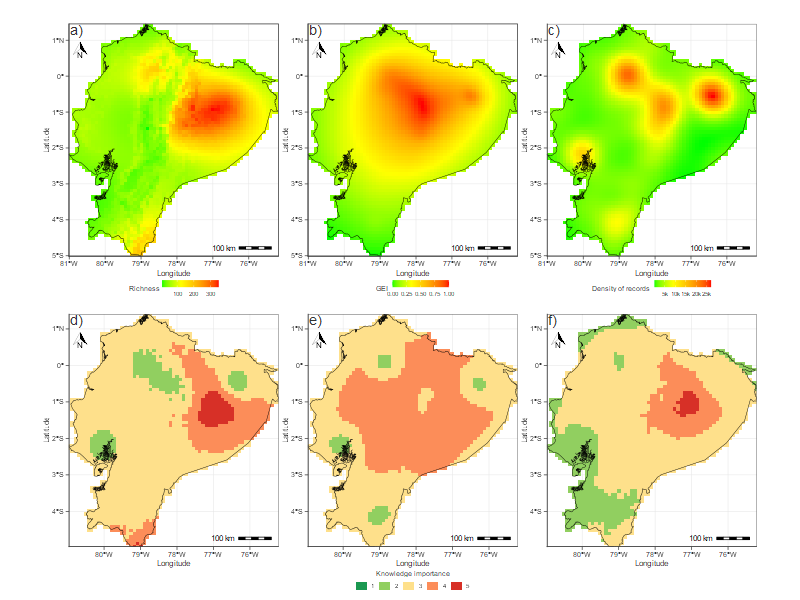

In [244]:
plots <- list(mapa_alpha, mapa_endemism,
  mapa_density, mapa_alpha_kg_likert,
  mapa_endemism_kg_likert, mapa_alpha_endemism_kg_likert)

wrap_diveristy_maps <- wrap_plots(plots, ncol = 3, byrow = TRUE) &
  theme(
    plot.margin = margin(t = 12, r = 2, b = 5, l = 2, unit = "pt")  # Incrementa margen superior e inferior
  )

wrap_diveristy_maps

In [245]:
ggsave(
  filename = "Results/Reports/Plots/diversity_maps.png",
  plot     = wrap_diveristy_maps,
  width    = 180, height = 200, units = "mm",
  dpi      = 600, bg = "white"
)


Warning messages:
1: Removed 1 row containing missing values or values outside the scale range
(`geom_tile()`). 
2: Removed 2 rows containing missing values or values outside the scale range
(`geom_tile()`). 
3: Removed 1 row containing missing values or values outside the scale range
(`geom_tile()`). 


### Summary

In [274]:
summary(alpha_div_df$valor)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10.95   51.97   73.72  103.75  131.48  347.49 

In [247]:
summary(endemism_df$valor)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.1852  0.3157  0.3712  0.5257  1.0000 

In [248]:
summary(density_df$valor)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   92.75  1699.72  2892.71  4790.91  6164.97 26993.00 

In [282]:
alpha_kg_likert_summary = alpha_kg_likert_df %>%
  group_by(valor)%>%
  summarise(Count= n())%>%
  ungroup()%>%
  mutate(Alpha_Percentage = round((Count/sum(Count))*100),2)%>%
  dplyr:: select(valor, Alpha_Percentage)

alpha_kg_likert_summary

# A tibble: 5 × 2
  valor Alpha_Percentage
  <fct>            <dbl>
1 1                    0
2 2                    8
3 3                   72
4 4                   17
5 5                    3

In [250]:
endemism_kg_likert_summary = endemism_kg_likert_df %>%
  group_by(valor)%>%
  summarise(Count= n())%>%
  ungroup()%>%
  mutate(Endemism_Percentage = round((Count/sum(Count))*100),2)%>%
  dplyr:: select( Endemism_Percentage)

endemism_kg_likert_summary

# A tibble: 5 × 1
  Endemism_Percentage
                <dbl>
1                   0
2                   3
3                  52
4                  45
5                   0

In [251]:
alpha_endemism_kg_likert_summary = alpha_endemism_kg_likert_df %>%
  group_by(valor)%>%
  summarise(Count= n())%>%
  ungroup()%>%
  mutate(Alpha_endemism_Percentage  = round((Count/sum(Count))*100),2)%>%
  dplyr:: select( Alpha_endemism_Percentage)

alpha_endemism_kg_likert_summary

# A tibble: 5 × 1
  Alpha_endemism_Percentage
                      <dbl>
1                         0
2                        20
3                        66
4                        12
5                         2

In [252]:
lables = c("very low", "low", "moderate", "high", "very high")
summary_kg = cbind( lables, alpha_kg_likert_summary,endemism_kg_likert_summary,alpha_endemism_kg_likert_summary)
summary_kg

     lables valor Alpha_Percentage Endemism_Percentage
1  very low     1                0                   0
2       low     2                8                   3
3  moderate     3               72                  52
4      high     4               17                  45
5 very high     5                3                   0
  Alpha_endemism_Percentage
1                         0
2                        20
3                        66
4                        12
5                         2

In [253]:
# -------------------------
# Crear workbook y hojas
# -------------------------
wb <- createWorkbook()

addWorksheet(wb, "summary_kg")
writeData(wb, sheet = "summary_kg", x = summary_kg)


out_file <- "Results/Reports/excels/summary_kg.xlsx"

saveWorkbook(wb, file = out_file, overwrite = TRUE)

Warning message:
In file.create(to[okay]) :
  cannot create file 'Results/Reports/excels/summary_kg.xlsx', reason 'Permission denied'


## Beta diversity

### NMDS 1

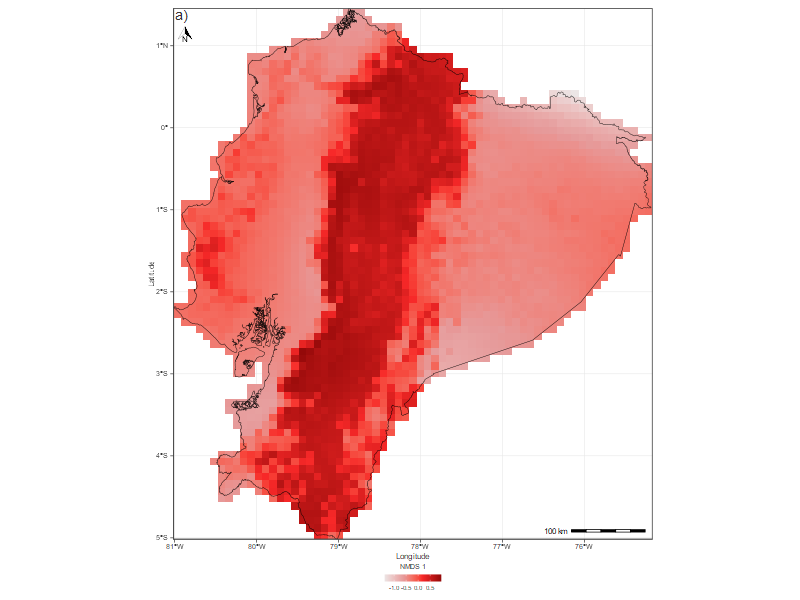

In [263]:
compact_legend <- theme(
  legend.position = "bottom",
  legend.key.size = unit(0.3, "cm"),
  legend.key.width = unit(0.8, "cm"),
  legend.key.height = unit(0.25, "cm"),
  legend.title = element_text(size = 7),
  legend.text = element_text(size = 6),
  legend.margin = margin(t = 0, r = 0, b = 0, l = 0),
  legend.box.spacing = unit(0.1, "cm")
)

nmds1 = nmds_stack[[1]]
nmds1_df <- as.data.frame(rasterToPoints(raster(nmds1)))
colnames(nmds1_df) <- c("longitud", "latitud", "valor")

# Convertir los valores de "valor" a numéricos
nmds1_df$valor <- as.numeric(nmds1_df$valor)

# Remover NAs
nmds1_df <- na.omit(nmds1_df)


# Crear mapa con escala de rojos
mapa_ndms1 <- ggplot() +
  # Usar geom_tile con fill basado en valor_stretched
  geom_tile(data = nmds1_df, 
            aes(x = longitud, y = latitud, fill = valor)) +
  
  # Capa del shapefile de Ecuador
  geom_sf(data = ecu, fill = NA, color = "black", size = 0.2) +
  
  # Escala de colores solo en rojo (usando gradiente de rojos)
  scale_fill_gradientn(
    colours = c("#ece5e5", "#e69a9a", "#f72828", "#940909"),  # Gradiente de rojos
    na.value = "transparent",
    name = "NMDS 1"  # Nombre de la leyenda
  ) +
  
  # Flecha del norte
  annotation_north_arrow(
    location = "tl", which_north = "true",
    pad_x = unit(0.06, "in"), pad_y = unit(0.25, "in"),
    height = unit(0.5, "cm"), width = unit(0.5, "cm"),
    style = north_arrow_orienteering(line_width = 0.2, text_size = 5.8)
  ) + 
  
  # Barra de leyenda personalizada
  guides(fill = guide_colorbar(
    barwidth = unit(2, "cm"),
    title.position = "top",
    title.hjust = 0.5
  )) +
  
  # Escala
  annotation_scale(location = "br", width_hint = 0.28, height = unit(0.09, "cm")) +
  
  # Coordenadas
  coord_sf(expand = FALSE) +
  
  # Temas
  theme_minimal() +
  base_theme +
  compact_legend +
  
  # Etiquetas
  labs(
    title = NULL,
    x = "Longitude",
    y = "Latitude"
  ) +
  
  # Anotación (a)
  annotate(
    "text",
    x = -Inf, y = Inf,
    label = "a)",
    hjust = -0.1, vjust = 1.1,
    size = 5,
    color = "grey20"
  )

mapa_ndms1

### NMDS 2

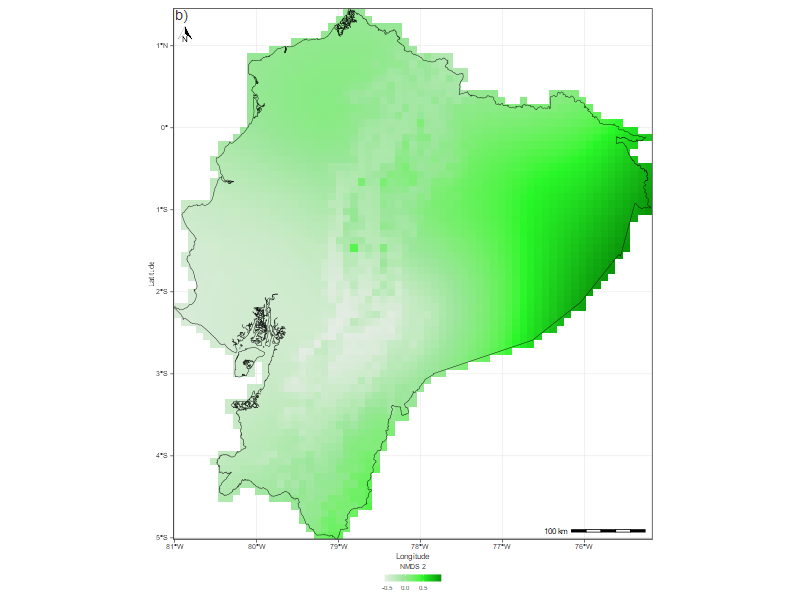

In [264]:


nmds2 = nmds_stack[[2]]
nmds2_df <- as.data.frame(rasterToPoints(raster(nmds2)))
colnames(nmds2_df) <- c("longitud", "latitud", "valor")

# Convertir los valores de "valor" a numéricos
nmds2_df$valor <- as.numeric(nmds2_df$valor)

# Remover NAs
nmds2_df <- na.omit(nmds2_df)


# Crear mapa con escala de rojos
mapa_ndms2 <- ggplot() +
  # Usar geom_tile con fill basado en valor_stretched
  geom_tile(data = nmds2_df, 
            aes(x = longitud, y = latitud, fill = valor)) +
  
  # Capa del shapefile de Ecuador
  geom_sf(data = ecu, fill = NA, color = "black", size = 0.2) +
  
  # Escala de colores solo en rojo (usando gradiente de rojos)
  scale_fill_gradientn(
    colours = c("#e5ece5", "#9ae69a", "#28f728", "#099409"),  # Gradiente de rojos
    na.value = "transparent",
    name = "NMDS 2"  # Nombre de la leyenda
  ) +
  
  # Flecha del norte
  annotation_north_arrow(
    location = "tl", which_north = "true",
    pad_x = unit(0.06, "in"), pad_y = unit(0.25, "in"),
    height = unit(0.5, "cm"), width = unit(0.5, "cm"),
    style = north_arrow_orienteering(line_width = 0.2, text_size = 5.8)
  ) + 
  
  # Barra de leyenda personalizada
  guides(fill = guide_colorbar(
    barwidth = unit(2, "cm"),
    title.position = "top",
    title.hjust = 0.5
  )) +
  
  # Escala
  annotation_scale(location = "br", width_hint = 0.28, height = unit(0.09, "cm")) +
  
  # Coordenadas
  coord_sf(expand = FALSE) +
  
  # Temas
  theme_minimal() +
  base_theme +
  compact_legend +
  
  # Etiquetas
  labs(
    title = NULL,
    x = "Longitude",
    y = "Latitude"
  ) +
  
  # Anotación (a)
  annotate(
    "text",
    x = -Inf, y = Inf,
    label = "b)",
    hjust = -0.1, vjust = 1.1,
    size = 5,
    color = "grey20"
  )

mapa_ndms2

### RG

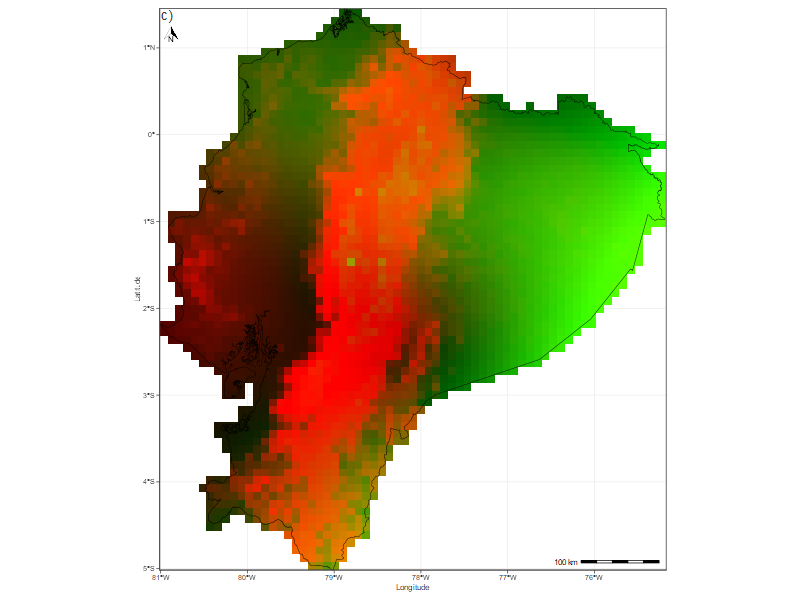

In [265]:
# Convertir de SpatRaster (terra) a RasterLayer (raster)
n1 <- raster(nmds1)
n2 <- raster(nmds2)

# Convertir a data frames con coordenadas
nmds_df1 <- as.data.frame(n1, xy = TRUE)
nmds_df2 <- as.data.frame(n2, xy = TRUE)

# Unir ambos data frames
df_nmds <- merge(nmds_df1, nmds_df2, by = c("x", "y"))
names(df_nmds) <- c("x", "y", "NMDS1", "NMDS2")

# Remover NAs
df_nmds <- na.omit(df_nmds)

# Stretch histogram - expande el contraste usando percentiles
hist_stretch <- function(x, percent = 0.02) {
  low <- quantile(x, percent, na.rm = TRUE)
  high <- quantile(x, 1 - percent, na.rm = TRUE)
  x[x < low] <- low
  x[x > high] <- high
  (x - low) / (high - low)
}

df_nmds$R <- hist_stretch(df_nmds$NMDS1)
df_nmds$G <- hist_stretch(df_nmds$NMDS2)

# Crear colores RGB
df_nmds$color <- rgb(df_nmds$R, df_nmds$G, 0)

# Plot con ggplot2
rg_map <- ggplot() +  # <-- IMPORTANTE: Sin aes() inicial
  # Primero la capa de raster
  geom_raster(data = df_nmds, aes(x = x, y = y), fill = df_nmds$color) +
  
  # Luego la capa de polígonos (sin aes)
  geom_sf(data = ecu, fill = NA, color = "black", size = 0.2, inherit.aes = FALSE) +
  
  # Flecha del norte
  annotation_north_arrow(
    location = "tl", which_north = "true",
    pad_x = unit(0.06, "in"), pad_y = unit(0.25, "in"),
    height = unit(0.5, "cm"), width = unit(0.5, "cm"),
    style = north_arrow_orienteering(line_width = 0.2, text_size = 5.8)
  ) + 
  
  # Escala
  annotation_scale(location = "br", width_hint = 0.28, height = unit(0.09, "cm")) +
  
  # Coordenadas
  coord_sf(expand = FALSE) +
  
  # Temas
  theme_minimal() +
  base_theme +
  
  # Etiquetas
  labs(
    title = NULL,
    x = "Longitude",
    y = "Latitude"
  ) +
  
  # Anotación (a)
  annotate(
    "text",
    x = -Inf, y = Inf,
    label = "c)",
    hjust = -0.1, vjust = 1.1,
    size = 5,
    color = "grey20"
  )

rg_map

### Cluster

 Ord.factor w/ 3 levels "1"<"2"<"3": 1 1 1 1 1 1 1 1 1 1 ...


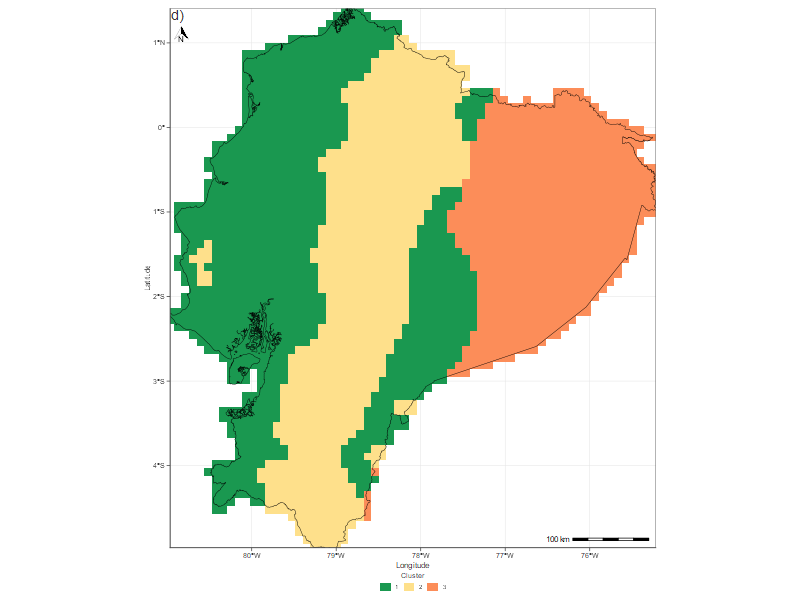

In [266]:
cluster_nmds_df <- as.data.frame(rasterToPoints(raster(cluster_nmds)))
colnames(cluster_nmds_df) <- c("longitud", "latitud", "valor")

# Likert discreto (1–5) con orden explícito
cluster_nmds_df <- cluster_nmds_df |>
  dplyr::filter(!is.na(valor)) |>
  dplyr::mutate(
    valor = factor(valor,
                   levels = c(1, 2, 3),
                   labels = c("1", "2", "3"),
                   ordered = TRUE)
  )

# SOLUCIÓN: Guardar los límites originales ANTES de agregar dummies
lon_limits <- range(cluster_nmds_df$longitud)
lat_limits <- range(cluster_nmds_df$latitud)

# Agregar filas dummy para niveles faltantes
niveles_faltantes <- setdiff(c("1", "2", "3"), 
                              unique(as.character(cluster_nmds_df$valor)))

if(length(niveles_faltantes) > 0) {
  dummy_rows <- data.frame(
    longitud = rep(NA, length(niveles_faltantes)),  # Usar NA en lugar de coordenadas lejanas
    latitud = rep(NA, length(niveles_faltantes)),
    valor = factor(niveles_faltantes, levels = c("1", "2", "3"))
  )
  
  cluster_nmds_df <- rbind(cluster_nmds_df, dummy_rows)
}

# Verificar
str(cluster_nmds_df$valor)
table(cluster_nmds_df$valor, useNA = "always")

mapa_cluster_nmds<- ggplot(cluster_nmds_df) +
  geom_tile(aes(x = longitud, y = latitud, fill = valor),show.legend = TRUE) +
  geom_sf(data = ecu, fill = NA, color = "black", size = 0.2) +
  scale_fill_manual(
    values = c("1" = "#1a9850",  # verde
               "2" = "#fee08b",  # amarillo
               "3" = "#fc8d59"), # rojo
    drop = FALSE,
    na.value = "transparent",
    name = "Cluster"
  ) +
  annotation_north_arrow(
    location = "tl", which_north = "true",
    pad_x = unit(0.06, "in"), pad_y = unit(0.25, "in"),
    height = unit(0.5, "cm"), width = unit(0.5, "cm"),
    style = north_arrow_orienteering(line_width = 0.2, text_size = 5.8)
  ) +
  annotation_scale(location = "br", width_hint = 0.28, height = unit(0.09, "cm")) +
  coord_sf(xlim = lon_limits, ylim = lat_limits, expand = FALSE) +  # Forzar límites originales
  theme_minimal() +
  base_theme +
  compact_legend +
  guides(
    fill = guide_legend(
      nrow = 1,
      keywidth = unit(0.4, "cm"),
      keyheight = unit(0.3, "cm"),
      title.position = "top",
      title.hjust = 0.5
    )
  ) +
  labs(
    title = NULL,
    x = "Longitude",
    y = "Latitude"
  ) +
  annotate(
    "text",
    x = -Inf, y = Inf,
    label = "d)",
    hjust = -0.1, vjust = 1.1,
    size = 5,
    color = "grey20"
  )

  mapa_cluster_nmds

### Final Map

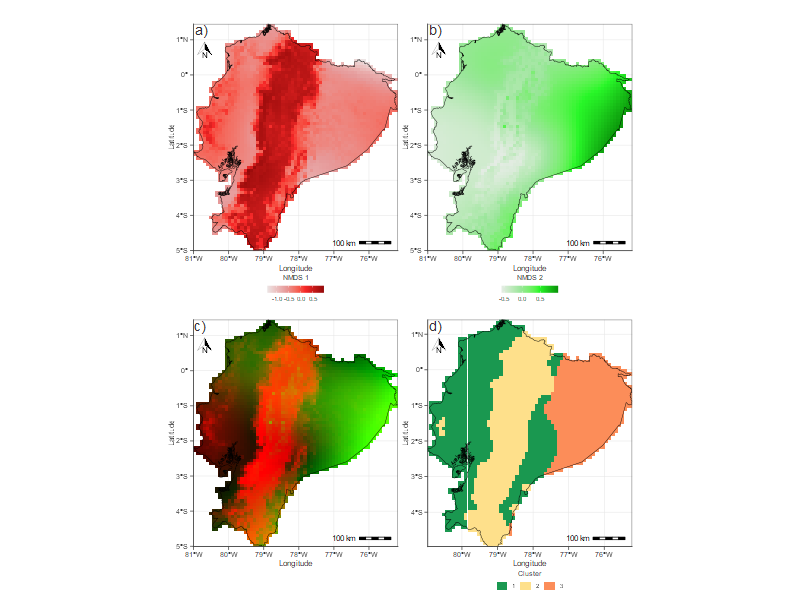

In [267]:
plots <- list(mapa_ndms1, mapa_ndms2,
  rg_map,mapa_cluster_nmds )

wrap_beta_diveristy_maps <- wrap_plots(plots, ncol = 2, byrow = TRUE) &
  theme(
    plot.margin = margin(t = 12, r = 2, b = 5, l = 2, unit = "pt")  # Incrementa margen superior e inferior
  )

  wrap_beta_diveristy_maps

In [271]:
ggsave(
  filename = "Results/Reports/Plots/beta_diversity_maps.png",
  plot     = wrap_beta_diveristy_maps,
  width    = 180, height = 200, units = "mm",
  dpi      = 600, bg = "white"
)

In [270]:
cluster_summary = cluster_nmds_df %>%
  group_by(valor)%>%
  summarise(Count= n())%>%
  ungroup()%>%
  mutate(Cluster_Percentage = round((Count/sum(Count))*100),2)%>%
  dplyr:: select(valor, Cluster_Percentage)%>%as.data.frame()

cluster_summary

  valor Cluster_Percentage
1     1                 42
2     2                 32
3     3                 26